In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from tqdm.notebook import tqdm

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop
from backprop import gp, srgp, cmgp, crossover, selector, library, project, diversify
from gp import evaluator as gp_evaluator
from symbols import syntax_tree

SAMPLE_SIZE = 200
NOISE = 0.0

POPSIZE = 1000
MAX_STREE_DEPTH = 5
GENERATIONS = 50
GROUP_SIZE = 5  # tournament selector.
MUTATION_RATE = 0.15
ELITISM = 1
BACKPROP_INTV = -1

NBESTS = 4

#logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

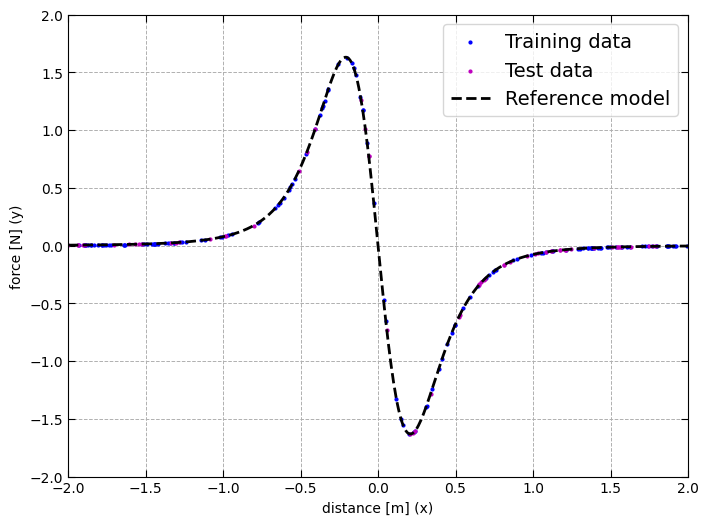

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')
S.split(train_size=0.7)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [3]:
#print(S_train.y.size)
#project.project(S_train, S.knowledge)
#project.project_semantic(S_train.y, S_train, S.knowledge)
#S_train.get_plotter().plot(width=8, height=6)

In [ ]:
syntax_tree.SyntaxTreeInfo.set_problem(S_train)

lib = library.Library(5, 3, S_train)
#lib.find_best_similarity()

trunks = None #gp.generate_trunks(3, S.nvars, S.knowledge)

solutionCreator = gp.RandomSolutionCreator(nvars=S.nvars, trunks=trunks)

multiMutator = gp.MultiMutator(
      gp.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp.FunctionSymbolMutator(),
      gp.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

#diversifier = None #gp.SemanticCrowdingDiversifier(S_train)
diversifier = diversify.SymbolicDiversifier(S_train, lib)

#evaluator = gp.R2Evaluator(S_train)
#evaluator = gp.FUEvaluator(S_train, S.knowledge)
#evaluator = gp.NumericalFUEvaluator(S_train, S.knowledge)
evaluator = gp_evaluator.FastFUEvaluator(S_train, S.knowledge)

selector = gp.TournamentSelector(GROUP_SIZE)

crossover2 = gp.SubTreeCrossover(MAX_STREE_DEPTH)
#crossover2 = crossover.ApproxGeometricCrossover(lib, MAX_STREE_DEPTH, diversifier)
#crossover2 = crossover.CrossNPushCrossover(lib, MAX_STREE_DEPTH)
#crossover2 = crossover.ConstrainedCrossNPushCrossover(lib, MAX_STREE_DEPTH, evaluator.know_evaluator)

projector = project.Projector(lib, S.knowledge)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover2,
               mutator=multiMutator,
               mutrate=MUTATION_RATE,
               diversifier=diversifier,
               projector=projector,
               elitism=ELITISM,
               backprop_intv=BACKPROP_INTV,
               knowledge=S.knowledge,
               trunks=trunks,
               nbests=NBESTS)

with np.errstate(all='ignore'):
      import profiling

      with tqdm(total=symb_regressor.ngen-1) as pbar:
            def on_newgen(genidx, status):
                  pbar.update(1)
                  pbar.set_description(status)
            best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)
      
      profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)

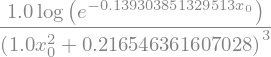

In [5]:
import sympy
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [6]:
best_stree.clear_output()
print(best_stree)
print(evaluator.evaluate(best_stree))

(log(cube(exp((x0 * -0.05)))) / cube((((x0 * x0) + (0.23 * -0.05)) + (0.59 * 0.38))))
know_mse:  0.0
know_nv:   0
know_n:    100
know_ls:   0
fea_ratio: 1.0
data_r2:   0.9998437399607696


In [7]:
print(best_stree.simplify())
print(best_stree.get_max_depth())
print(best_stree.get_nnodes())
#from backprop import lpbackprop
#sat, stree_cost = lpbackprop.lpbackprop(S.knowledge, best_stree, None)
#print(sat)

K_derivs = S.knowledge.get_derivs()
stree_derivs = backprop.SyntaxTree.diff_all(best_stree, K_derivs, include_zeroth=True)
print(sympy.simplify(sympy.factor(stree_derivs[(0,0)].to_sympy())))

print(gp.NumericalFUEvaluator(S_train, S.knowledge).evaluate(best_stree, eval_deriv=True))

(log(cube(exp((x0 * -0.05)))) / cube((((x0 * x0) + (0.23 * -0.05)) + (0.59 * 0.38))))
5
19
(1.67164621595416*x0**5 + 42.0*x0**4*log(exp(-0.139303851329513*x0)) + 0.72397781191806*x0**3 + 7.79566901785302*x0**2*log(exp(-0.139303851329513*x0)) + 0.0783873805275366*x0 - 0.281353960351451*log(exp(-0.139303851329513*x0)))/(1.0*x0**2 + 0.216546361607028)**6
know_mse:  0.47765404994019084
know_nv:   140
know_n:    80
know_ls:   True
fea_ratio: -0.75
data_r2:   0.9998437399607696


(log(cube(exp((x0 * -0.05)))) / cube((((x0 * x0) + (0.23 * -0.05)) + (0.59 * 0.38))))


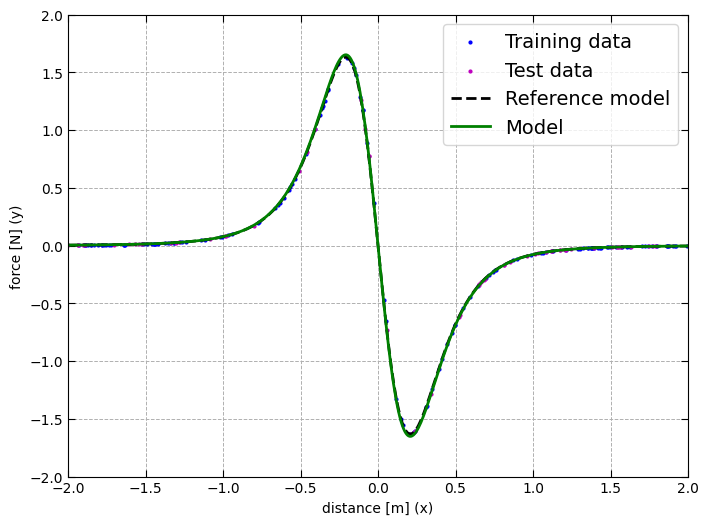

'S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree.diff(0).simplify(), zoomout=3)\nS.knowledge.synthesize(best_stree, S_train.X).get_plotter().plot(width=8, height=6)\n\nK_evaluator = gp.FUEvaluator(S_train, S.knowledge)\nprint(K_evaluator.evaluate(best_stree))\n\nprint(best_stree.diff(0))\nprint(best_stree.diff(0).simplify())'

In [8]:
best_stree.clear_output()

print(best_stree)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
"""S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree.diff(0).simplify(), zoomout=3)
S.knowledge.synthesize(best_stree, S_train.X).get_plotter().plot(width=8, height=6)

K_evaluator = gp.FUEvaluator(S_train, S.knowledge)
print(K_evaluator.evaluate(best_stree))

print(best_stree.diff(0))
print(best_stree.diff(0).simplify())"""

currBest [0.2998936138876891, 0.30000853204916433, 0.30000853204916433, 0.5781339400339462, 0.5859021128680952, 0.8946336610854115, 0.8946336610854115, 0.8946336610854115, 0.9907107935213582, 0.9907107935213582, 0.9907107935213582, 0.9907107935213582, 0.991328882663119, 0.991328882663119, 0.991328882663119, 0.991328882663119, 0.991328882663119, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9957921437963279, 0.9984265449998901, 0.9984265449998901, 0.9984265449998901, 0.9984265449998901, 0.9984265449998901, 0.9984265449998901, 0.9984265449998901, 0.9984265449998901, 0.9993085510467846, 0.9993085510467846, 0.9993085510467846, 0.9993085510467846, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.9998437399607696, 0.99984373996

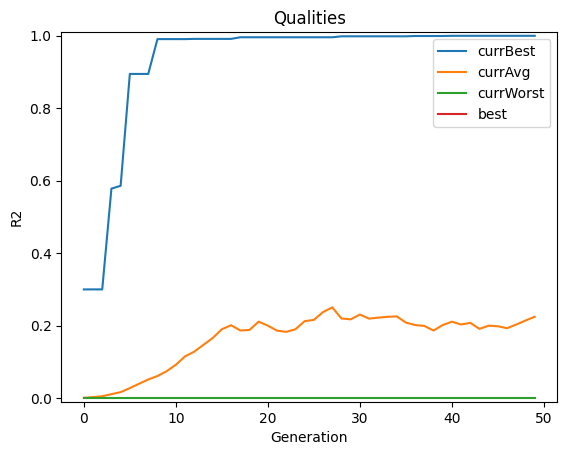

In [9]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)
    print(quality, qseries)
plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

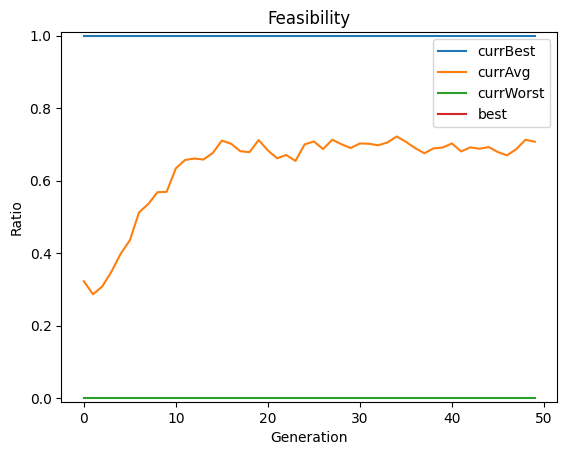

In [10]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

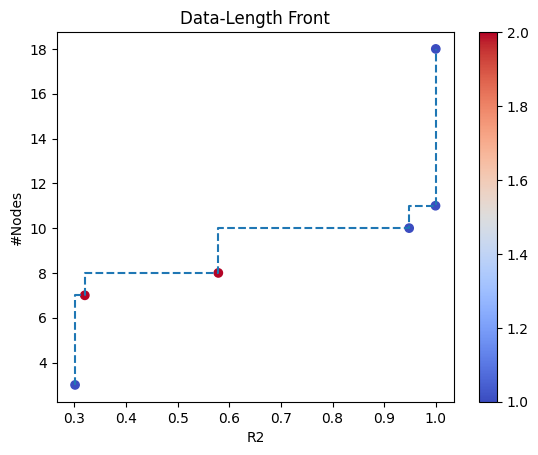

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(log(cube(exp((x0 * -0.05)))) / cube(((square(...,0,0.055547,0.999844,18,"(+, /, cube, exp, square, log)",1,inf
1,1,(-0.07 / x0),0,0.100444,0.301331,3,(/),1,inf
2,2,((x0 / -0.29) / square(exp(square(x0)))),0,0.072342,0.578733,8,"(square, /, exp)",2,1.099162
3,3,((-0.13 * x0) / cube(((x0 * x0) + 0.23))),0,0.094829,0.948286,10,"(*, /, cube)",1,0.802101
4,4,(x0 / (-0.73 * exp(square(x0)))),0,0.045744,0.320210,7,"(square, /, exp)",2,0.730466
5,5,((-0.13 * x0) / cube((square(x0) + (0.59 - 0.3...,0,0.090846,0.999309,11,"(square, /, +, cube)",1,0.607144
6,0,(-0.06 / x0),1,0.099965,0.299894,3,(/),1,inf
7,1,(log(cube(exp((x0 * -0.05)))) / cube((((x0 * x...,1,0.052623,0.999844,19,"(*, +, /, cube, exp, log)",1,inf
8,2,((x0 / square(exp(square(x0)))) / -0.38),1,0.071625,0.572996,8,"(square, /, exp)",2,0.780952
9,3,((-0.13 * x0) / cube(((x0 * x0) + (0.59 - 0.38...,1,0.083276,0.999309,12,"(*, /, +, cube)",1,0.744308


In [11]:
import pandas as pd

pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

        

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)
